In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 690 kB/s 
     |████████████████████████████████| 6.4 MB 24.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import time
import datetime
import pandas as pd


tickers = ['TSLA', 'TWTR', 'MSFT', 'GOOG', 'AAPL', '^GSPC']
interval = '1d'
period1 = int(time.mktime(datetime.datetime(2018, 5, 20, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 5, 20, 23, 59).timetuple()))

xlwriter = pd.ExcelWriter('historical prices.xlsx', engine='openpyxl')
for ticker in tickers:
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df = pd.read_csv(query_string)
    df.to_excel(xlwriter, sheet_name=ticker, index=False)

xlwriter.save()

In [ ]:
data = pd.ExcelFile('/content/historical prices.xlsx')

In [ ]:
aapl = pd.read_excel(data, 'AAPL')
df = aapl

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-21,47.000000,47.317501,46.727501,46.907501,45.096020,73603200
1,2018-05-22,47.095001,47.220001,46.695000,46.790001,44.983051,60962800
2,2018-05-23,46.587502,47.125000,46.439999,47.090000,45.271473,80233600
3,2018-05-24,47.192501,47.209999,46.552502,47.037498,45.221001,92936000
4,2018-05-25,47.057499,47.412498,46.912498,47.145000,45.324348,69844000
...,...,...,...,...,...,...,...
1004,2022-05-16,145.550003,147.520004,144.179993,145.539993,145.539993,86643800
1005,2022-05-17,148.860001,149.770004,146.679993,149.240005,149.240005,78336300
1006,2022-05-18,146.850006,147.360001,139.899994,140.820007,140.820007,109742900
1007,2022-05-19,139.880005,141.660004,136.600006,137.350006,137.350006,136095600


In [ ]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

np.warnings.filterwarnings('ignore')

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

In [ ]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2018-05-21,47.000000,47.317501,46.727501,46.907501,45.096020,73603200,5
1,2018-05-22,47.095001,47.220001,46.695000,46.790001,44.983051,60962800,5
2,2018-05-23,46.587502,47.125000,46.439999,47.090000,45.271473,80233600,5
3,2018-05-24,47.192501,47.209999,46.552502,47.037498,45.221001,92936000,5
4,2018-05-25,47.057499,47.412498,46.912498,47.145000,45.324348,69844000,5
5,2018-05-29,46.900002,47.187500,46.717499,46.974998,45.160912,90056400,5
6,2018-05-30,46.930000,47.000000,46.695000,46.875000,45.064770,74762000,5
7,2018-05-31,46.805000,47.057499,46.535000,46.717499,44.913364,109931200,5
8,2018-06-01,46.997501,47.564999,46.937500,47.560001,45.723324,93770000,6
9,2018-06-04,47.910000,48.355000,47.837502,47.957500,46.105473,105064800,6


Text(0, 0.5, 'USD')

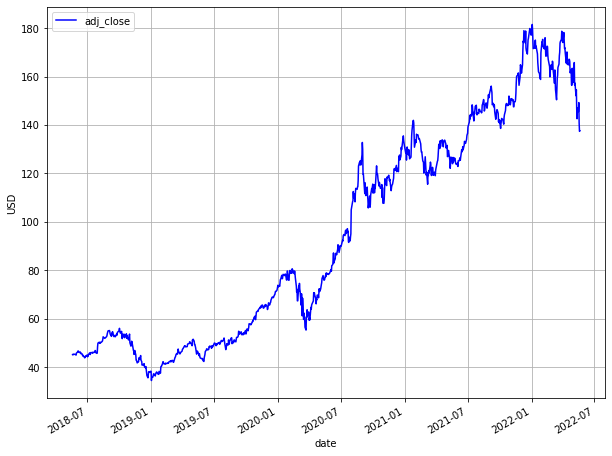

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 607
num_cv = 201
num_test = 201
train.shape = (607, 8)
cv.shape = (201, 8)
train_cv.shape = (808, 8)
test.shape = (201, 8)


Text(0, 0.5, 'USD')

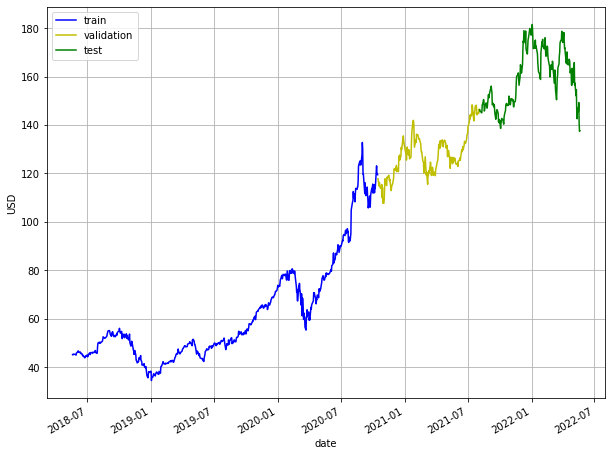

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [2.222314451870466, 2.4168783882085867, 2.662151096635405, 2.888718883978034, 3.115594903648053, 3.3006089503022853, 3.470002758802195, 3.631814168370077, 3.7976604000948697, 3.9584788504517086, 4.117299387747613, 4.28316312391304, 4.443670908071408, 4.594676190910074, 4.733602099209375, 4.865955928684599, 5.002546773535283, 5.133003774049932, 5.271300661182405, 5.414347824528741, 5.5564792707041555]
MAPE = [1.3559742257449707, 1.4702657441173246, 1.6435544683858876, 1.7644405446025295, 1.9237196380545134, 2.053625214103183, 2.151149546291578, 2.2448407125747822, 2.353454707658657, 2.458806392738878, 2.560952041915413, 2.6661178381192014, 2.765876362020346, 2.862448767646486, 2.9534171187736784, 3.039380304399652, 3.1308635759516528, 3.209290267267221, 3.302294025038148, 3.396793296093136, 3.488766847624606]


,date,open,high,low,close,adj_close,volume,month
0,2018-05-21,47.000000,47.317501,46.727501,46.907501,45.096020,73603200,5
1,2018-05-22,47.095001,47.220001,46.695000,46.790001,44.983051,60962800,5
2,2018-05-23,46.587502,47.125000,46.439999,47.090000,45.271473,80233600,5
3,2018-05-24,47.192501,47.209999,46.552502,47.037498,45.221001,92936000,5
4,2018-05-25,47.057499,47.412498,46.912498,47.145000,45.324348,69844000,5


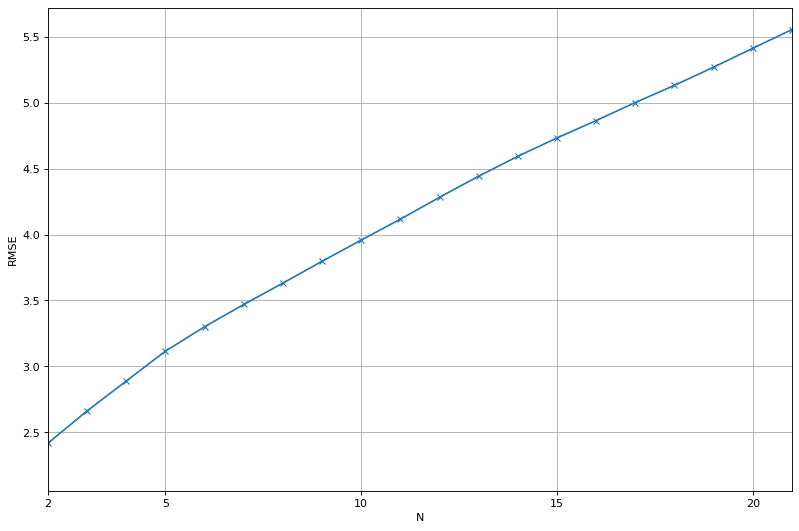

In [ ]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])
matplotlib.rcParams.update({'font.size': 14})

([<matplotlib.axis.XTick at 0x7fe0381ae090>,
 <a list of 5 Text major ticklabel objects>)

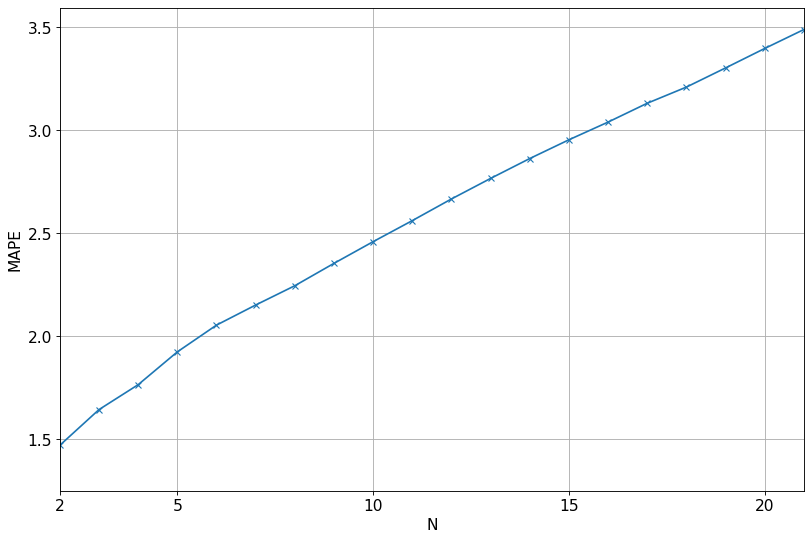

In [ ]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

In [ ]:
# Set optimum N
N_opt = 2

Text(0, 0.5, 'USD')

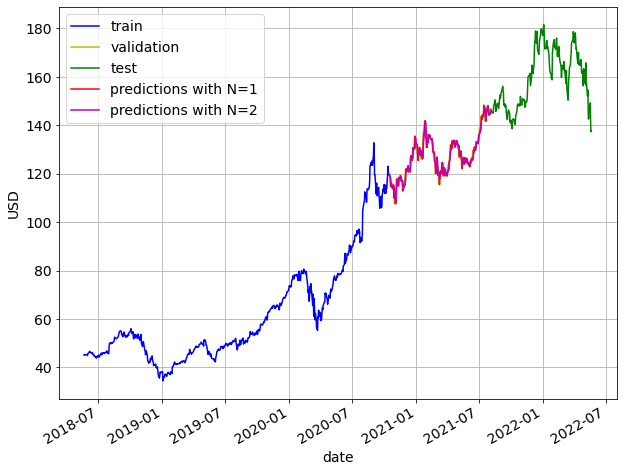

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

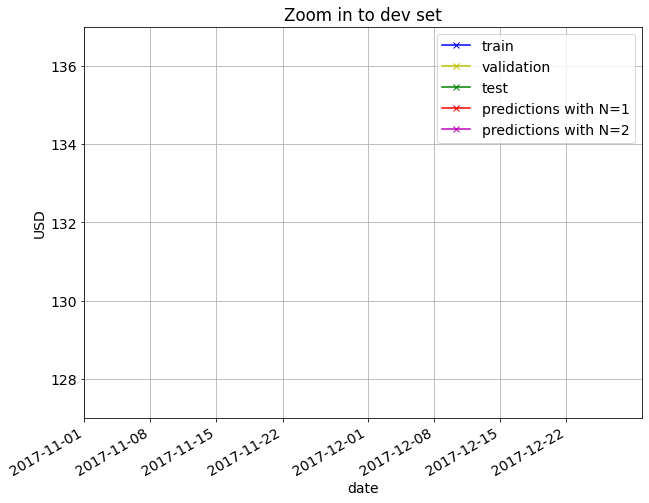

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 11, 1), date(2017, 12, 30)])
ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

In [ ]:
est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 3.308
MAPE = 1.630%


,date,open,high,low,close,adj_close,volume,month,est_N2
808,2021-08-05,146.979996,147.839996,146.169998,147.059998,146.224594,46397700,8,146.319053
809,2021-08-06,146.350006,147.110001,145.630005,146.139999,145.527512,54126800,8,146.169906
810,2021-08-09,146.199997,146.699997,145.520004,146.089996,145.477722,48908700,8,145.876053
811,2021-08-10,146.440002,147.710007,145.300003,145.600006,144.989792,69023100,8,145.502617
812,2021-08-11,146.050003,146.720001,145.529999,145.860001,145.248688,48493500,8,145.233757


Text(0, 0.5, 'USD')

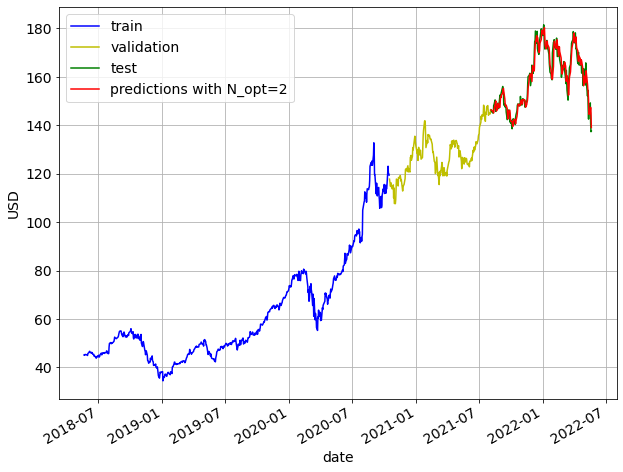

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

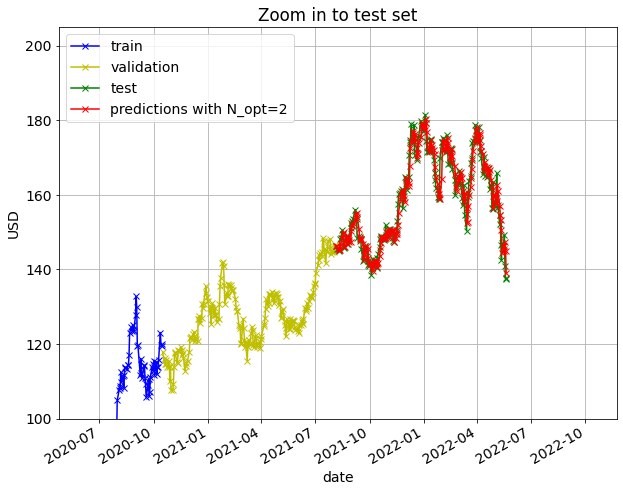

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 4, 23), date(2022, 11, 23)])
ax.set_ylim([100, 205])
ax.set_title('Zoom in to test set')

(130.0, 155.0)

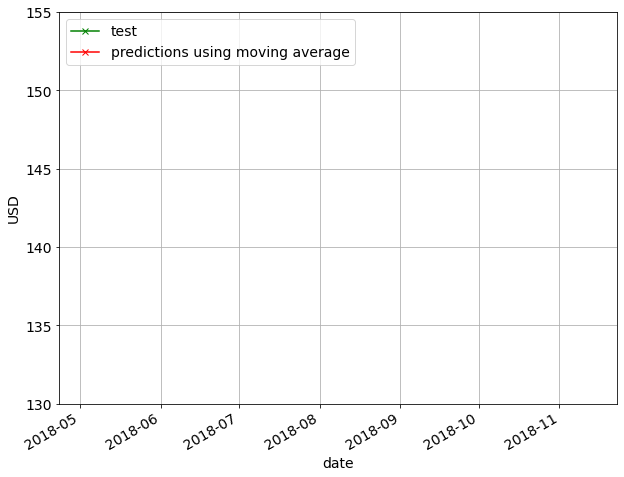

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using moving average'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_ylim([130, 155])